<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW%E2%80%94FCNN/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os
import zipfile

In [2]:
dataset_dir = "./fake_news_dataset"

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# download the dataset
dataset_name = "emineyetm/fake-news-detection-datasets"
print(f"Downloading dataset: {dataset_name}")
os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_dir}")

# Extract the dataset
zip_file = None
for file in os.listdir(dataset_dir):
    if file.endswith(".zip"):
        zip_file = os.path.join(dataset_dir, file)
        break

if not zip_file:
    raise FileNotFoundError("No zip file found in the dataset directory.")

print(f"Extracting {zip_file}...")
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

# Dynamically locate CSVs
fake_path, true_path = None, None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Fake.csv" in file:
            fake_path = os.path.join(root, file)
        if "True.csv" in file:
            true_path = os.path.join(root, file)

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add labels and combine datasets
fake_df['label'] = 0
true_df['label'] = 1
df = pd.concat([fake_df, true_df]).reset_index(drop=True)

print("Combined Dataset Preview:")
print(df.head())
print("\nDataset statistics:")
print(df.describe())

Extracting ./fake_news_dataset/fake-news-detection-datasets.zip...
Combined Dataset Preview:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  

Data

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) > 50 and text not in new_data:
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [4]:
# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:
# Define NN
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())


Epoch 1/10, Loss: 68.8717
Epoch 2/10, Loss: 8.6904
Epoch 3/10, Loss: 2.2698
Epoch 4/10, Loss: 0.6958
Epoch 5/10, Loss: 0.3747
Epoch 6/10, Loss: 0.2972
Epoch 7/10, Loss: 0.7089
Epoch 8/10, Loss: 1.2710
Epoch 9/10, Loss: 0.1339
Epoch 10/10, Loss: 0.0454



Model Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3422
        True       0.99      1.00      0.99      4277

    accuracy                           0.99      7699
   macro avg       0.99      0.99      0.99      7699
weighted avg       0.99      0.99      0.99      7699



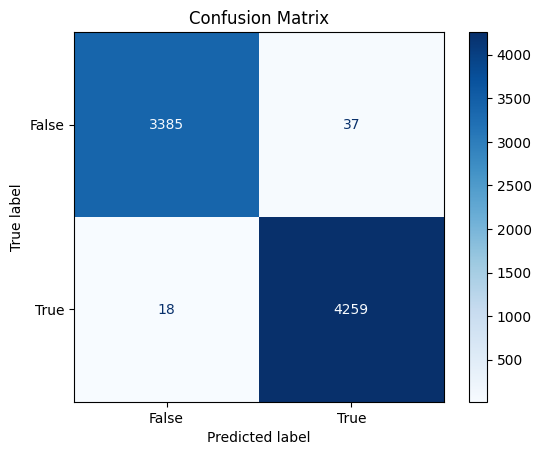


Sample Predictions:

Sample 1
Text: washington reuters  president barack obama did not specify a candidate preference in the race for the democratic presidential nomination at a democratic national committee fundraising event white house spokesman josh earnest told reporters on thursday earnest was asked about a new york times report that said obama told democratic donors to rally behind candidate hillary clinton during the fundraiser in austin texas last weekend  
Predicted: True, Actual: True

Sample 2
Text: sen john mccain is fed up with donald trump and his big mouth following trump s illadvised decision to challenge north korea with  fire and fury  the arizona republican let him know it in no uncertain termsspeaking about trump s latest bluster and bravado regarding nuclear war mccain told an arizona radio station that he  takes exception to the president s words because you got to be sure you can do what you say you re going to do  he then added that he doesn t even know what th

In [6]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")